<a href="https://colab.research.google.com/github/JulioHenri/Houses-to-rent/blob/master/houses_to_rent3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Houses to rent in Brazil

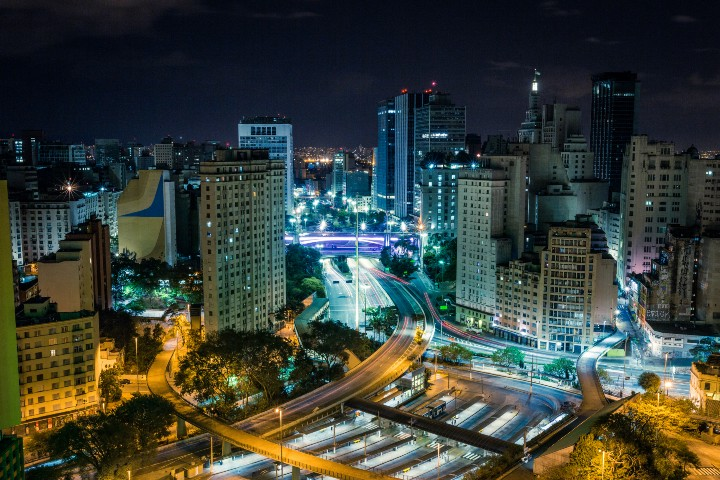

The economic crisis resulting from the pandemic of the Corona Virus caused several alerts in the housing market. Buying, selling or renting houses needs to be well analyzed, and house market analysis has been well documented in several papers.

In this notebook I want encourage critical thinking and explore data and features about housing market to have the best performance. It’s ideal for people who started in data science world and want to know about Linear Regression and how to perform analysis housing market data. I hope you enjoy this study!

In this notebook I used Linear Regression in practice, that is, i'll analyze the data and features to have the best perfomance I can. I used a Dataset from <a href='https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent'>Kaggle</a> and you can see my post in <a href='https://medium.com/@henrijulio2/houses-to-rent-in-brazil-multiple-linear-regression-solve-5fb7c35786bc'>Medium</a> 


# Objective

Questions to be answered:

1. What is the distribution of furnished and unfurnished houses by city? <br>
2. What is the most common rent amount among houses that accept
animals and do not accept and how much do they differ? <br>
3. What is the relationship between the number of rooms and the area of the house? <br>
4. What is the correlation between the variables? <br>
5. How good is my model? <br>

And, of course, I need to predict the value of rent amount based on features selected.

# The dataset

This Dataset contains: <br>
**City**: City where the property is located <br>
**Area**: Size of area <br>
**Rooms**: Quantity of rooms <br>
**Bathroom**: Quantity of bathrooms <br>
**Parking spaces**: Quantity of parking spaces <br>
**Floor**: Quantity of floors <br>
**Animal**: If accept animals (1) or not (0)<br>
**Furniture**: If it is furnished (1) or not (0)<br>
**Hoa**: Homeowners association tax <br>
**Rent amount**: Rent amount in Real <br>
**Property tax**: Property tax in Real <br>
**Fire insurance**: Fire insurance in Real <br>
**Total**: Total amount in Real <br>

# Proposed metrics 

The metrics that will be used are primarily the Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE), but I will also show the adjusted r2 for information.

<a href='https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d'>Here</a> you can see the comparison between RMSE and MAE. <br>
<a href='https://www.statisticshowto.com/adjusted-r2/'>Here</a> 
 you can understand more about the adjusted r2 (and your problems).

# Importing Libs

In [ ]:
import pandas as pd 
import numpy as np 

import seaborn as sns 
import matplotlib.pyplot as plt

import statsmodels.api as sm 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

%matplotlib inline
sns.set_style('darkgrid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading and Reading the Data

In [ ]:
houses = pd.read_csv('dataset.csv')
houses.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


# Exploring the data

In [ ]:
houses.shape #checking shape of dataset

(10692, 13)

In [ ]:
houses.info() #looking for null numbers and type of columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 10692 non-null  object
 1   area                 10692 non-null  int64 
 2   rooms                10692 non-null  int64 
 3   bathroom             10692 non-null  int64 
 4   parking spaces       10692 non-null  int64 
 5   floor                10692 non-null  object
 6   animal               10692 non-null  object
 7   furniture            10692 non-null  object
 8   hoa (R$)             10692 non-null  int64 
 9   rent amount (R$)     10692 non-null  int64 
 10  property tax (R$)    10692 non-null  int64 
 11  fire insurance (R$)  10692 non-null  int64 
 12  total (R$)           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


In Machine Learning models, letters and whatever is not a number make machine learning more difficult, so I will have to choose which variables to use in the model and convert them into numbers. 

In [ ]:
houses.describe().round(2) #Analyzing the data's stats

,area,rooms,bathroom,parking spaces,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
count,10692.00,10692.00,10692.00,10692.00,10692.00,10692.00,10692.00,10692.00,10692.00
mean,149.22,2.51,2.24,1.61,1174.02,3896.25,366.70,53.30,5490.49
std,537.02,1.17,1.41,1.59,15592.31,3408.55,3107.83,47.77,16484.73
min,11.00,1.00,1.00,0.00,0.00,450.00,0.00,3.00,499.00
25%,56.00,2.00,1.00,0.00,170.00,1530.00,38.00,21.00,2061.75
50%,90.00,2.00,2.00,1.00,560.00,2661.00,125.00,36.00,3581.50
75%,182.00,3.00,3.00,2.00,1237.50,5000.00,375.00,68.00,6768.00
max,46335.00,13.00,10.00,12.00,1117000.00,45000.00,313700.00,677.00,1120000.00


Notes

1. The variable "area" has a min of 11 and a max of 46335, which shows the large value of the std <br>
2. There are no null values, but the variable "hoa" and "property tax" have a minimum value of 0, which will be treated. <br>
3. Most houses have 1 to 3 rooms, 1 to 3 bathrooms and 0 to 2 parking spaces.

In [ ]:
#change spaces for underscores
cols = houses.columns
cols = cols.map(lambda x: x.replace(' ','_') if isinstance(x, (str)) else x)
houses.columns = cols 

#change the categorical variables
houses.animal.replace(['acept','not acept'],[1,0], inplace = True)
houses.furniture.replace(['furnished','not furnished'],[1,0], inplace = True)

#change "$" for use queries
houses.rename(columns={'hoa_(R$)' : 'hoa',
                        'rent_amount_(R$)' : 'rent_amount',
                        'property_tax_(R$)' : 'property_tax',
                        'fire_insurance_(R$)' : 'fire_insurance',
                        'total_(R$)' : 'total'}, inplace = True)
houses.head()

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
0,São Paulo,70,2,1,1,7,1,1,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,1,0,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,1,0,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,1,0,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,0,0,0,800,25,11,836


In [ ]:
houses.floor.unique() # 301 !?

array(['7', '20', '6', '2', '1', '-', '4', '3', '10', '11', '24', '9',
       '8', '17', '18', '5', '13', '15', '16', '14', '26', '12', '21',
       '19', '22', '27', '23', '35', '25', '46', '28', '29', '301', '51',
       '32'], dtype=object)

I'll handle with this later.

# Data Viz

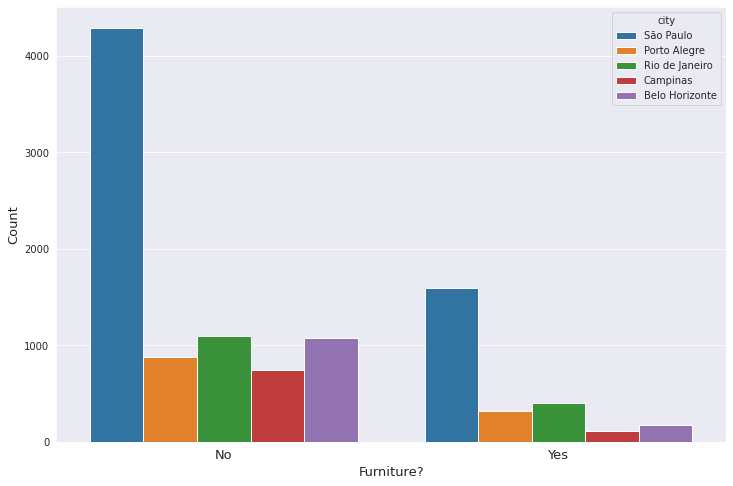

In [ ]:
ax = sns.countplot(houses['furniture'], hue = houses['city'])
ax.figure.set_size_inches(12, 8)
ax.set_xlabel('Furniture?', fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_xticklabels(['No','Yes'], fontsize=13)
ax

Note that the city of São Paulo has more data than other cities. In addition, it's also possible to identify that in the dataset are more houses for rent that are not furnished

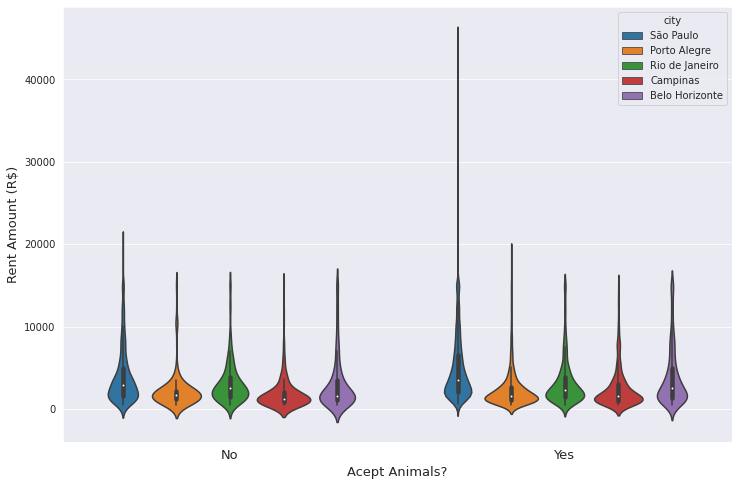

In [ ]:
ax = sns.violinplot(x ='animal', y ='rent_amount', data = houses, hue ='city')
ax.figure.set_size_inches(12, 8)
ax.set_xlabel('Acept Animals?', fontsize=13)
ax.set_ylabel('Rent Amount (R$)', fontsize=13)
ax.set_xticklabels(['No','Yes'], fontsize=13)
ax

In graph above I observed the biggest rent amount is from São Paulo and I can see that animals (if accept or no) distribution is similar

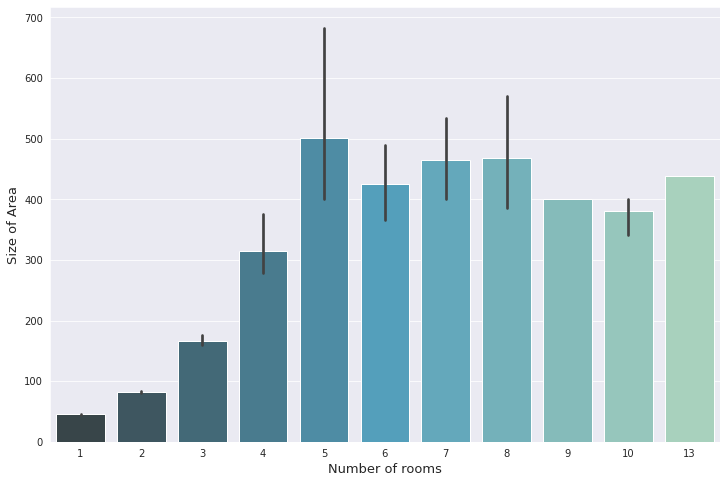

In [ ]:
ax = sns.barplot(x='rooms', y='area', data = houses, palette = 'GnBu_d')
ax.set_xlabel('Number of rooms', fontsize=13)
ax.set_ylabel('Size of Area', fontsize=13)
ax.figure.set_size_inches(12, 8)

I wanted see the relationship between area and rooms. Until 5 rooms have a crescent and then stabilize with little variation

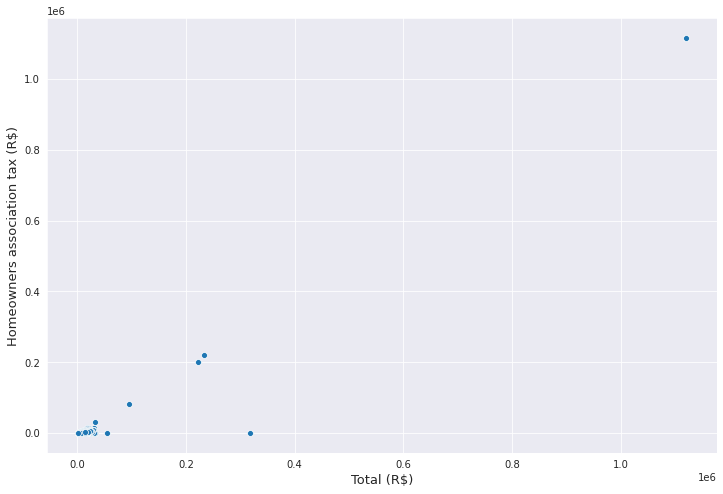

In [ ]:
ax = sns.scatterplot(x = 'total', y = 'hoa', data = houses)
ax.set_xlabel('Total (R$)', fontsize=13)
ax.set_ylabel('Homeowners association tax (R$)', fontsize=13)
ax.figure.set_size_inches(12, 8)

Outlier making a difficult visualization

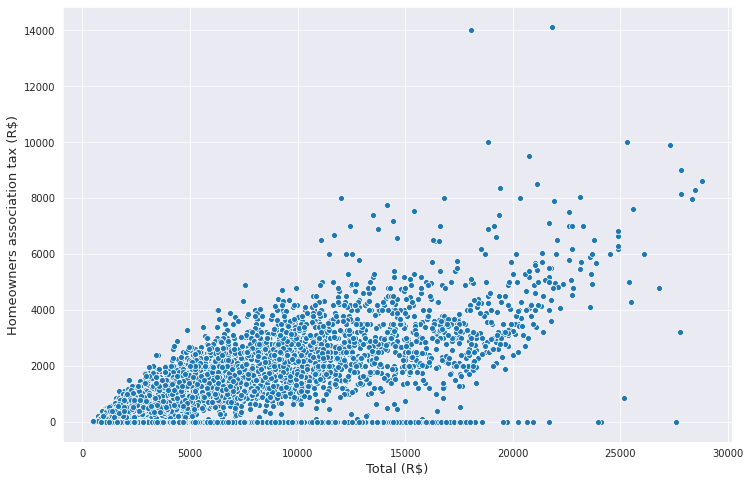

In [ ]:
houses = houses.drop(labels=houses[(houses['hoa'] > 300000)].index)
houses = houses.drop(labels=houses[(houses['total'] > 30000)].index)
             
ax = sns.scatterplot(x = 'total', y = 'hoa', data = houses)
ax.set_xlabel('Total (R$)', fontsize=13)
ax.set_ylabel('Homeowners association tax (R$)', fontsize=13)
ax.figure.set_size_inches(12, 8)

Better now! Observe the crescent

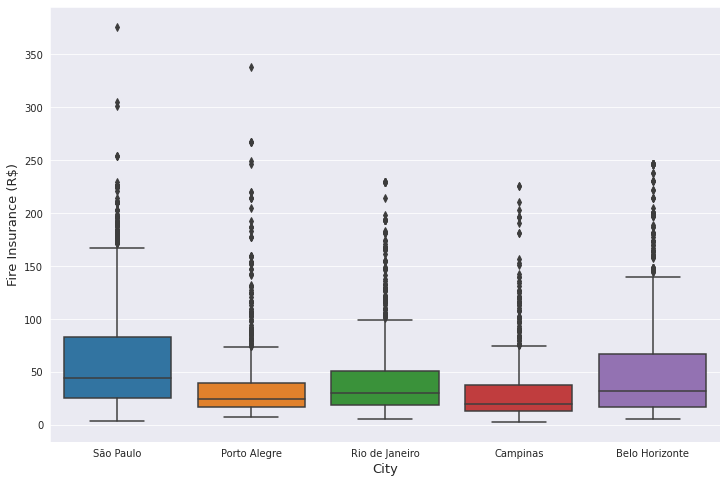

In [ ]:
ax = sns.boxplot(x = 'city', y = 'fire_insurance', data = houses)
ax.figure.set_size_inches(12, 8)
ax.set_xlabel('City', fontsize=13)
ax.set_ylabel('Fire Insurance (R$)', fontsize=13)
ax

São Paulo has the biggest median of fire insurance, than Belo Horizonte and Rio de Janeiro but São Paulo has more Outliers than anyone.

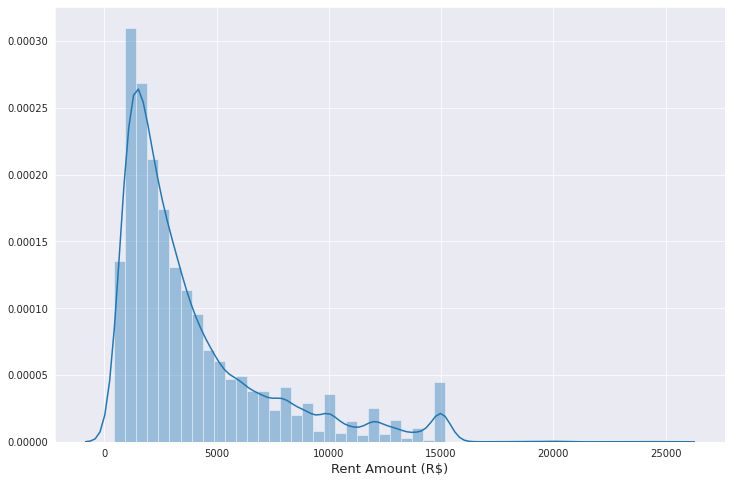

In [ ]:
ax = sns.distplot(houses.rent_amount)
ax.figure.set_size_inches(12, 8)
ax.set_xlabel('Rent Amount (R$)', fontsize=13)
ax

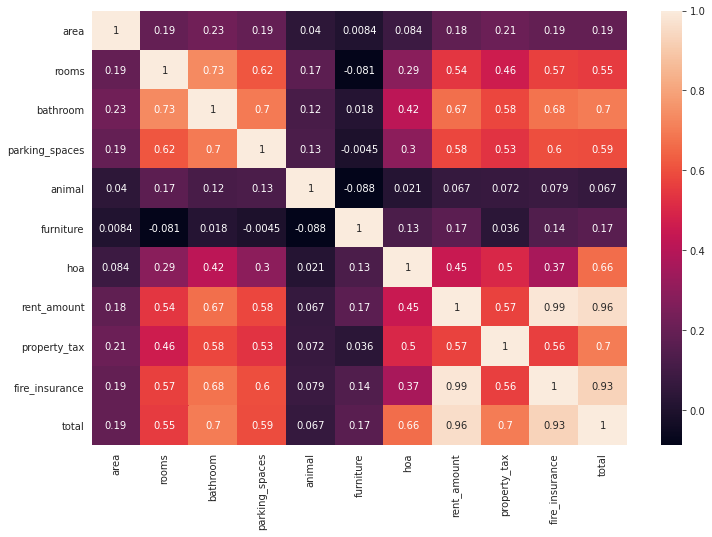

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(houses.corr(), annot=True)

As you can see, not all features are correlated with the dependent variable rent_amount. Hence i will drop all other features apart from these. However this is not the end of the process. One of the assumptions of linear regression is that the independent variables need to be uncorrelated with each other. If these variables are correlated with each other, then we need to keep only one of them and drop the rest. So let's check the correlation of selected features with each other. This can be done either by visually checking it from the above correlation matrix.

In [ ]:
houses.floor.replace(['-'],[0], inplace = True)
houses = houses.astype({'floor':'int64' ,'animal':'int64', 'furniture':'int64'})
houses.dtypes

city              object
area               int64
rooms              int64
bathroom           int64
parking_spaces     int64
floor              int64
animal             int64
furniture          int64
hoa                int64
rent_amount        int64
property_tax       int64
fire_insurance     int64
total              int64
dtype: object

In [ ]:
houses.drop(inplace = True, labels=houses[(houses['floor'] == 301)].index)

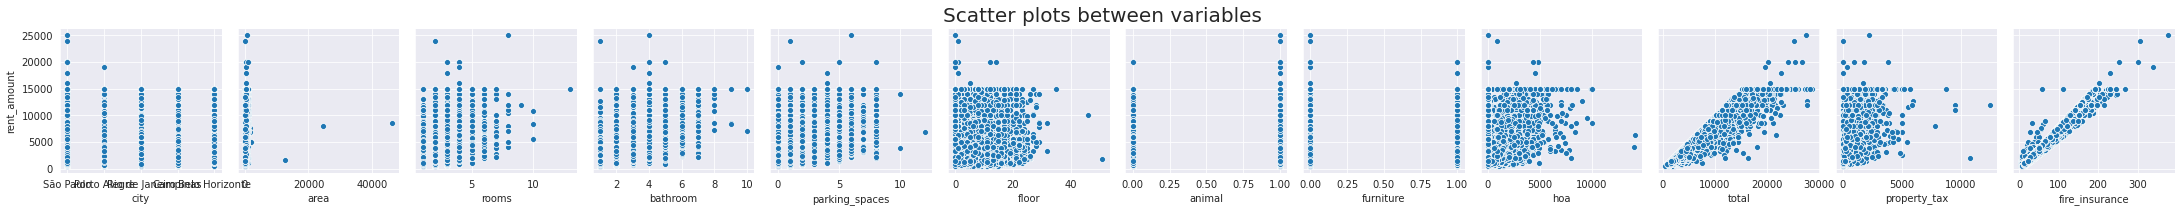

In [ ]:
ax = sns.pairplot(houses, y_vars='rent_amount', x_vars=['city', 'area', 'rooms',
                  'bathroom', 'parking_spaces', 'floor', 'animal', 'furniture',
                  'hoa', 'total', 'property_tax', 'fire_insurance'])
ax.fig.suptitle('Scatter plots between variables', fontsize=20, y=1.1)
ax

The column "area" contains some Outliers that can be a rock in the way. For this i'll handle later.

# First model

Will be my baseline.

In [ ]:
metrics = []

y = houses['rent_amount'] #Creating a Series for target variable
x = houses.drop(['rent_amount','city','parking_spaces', 'area','bathroom',
                 'furniture','animal','floor','rooms', 'total'], axis = 1) #Creating a DF for explanatory variables 

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                   test_size=0.3,
                                                   random_state = 8) #Splitting data arrays into two subsets

reg = LinearRegression() #Instantiating the model
reg.fit(x_train, y_train) #Training data
predict = reg.predict(x_test) #Predict

x_train_constant = sm.add_constant(x_train)
model_sm = sm.OLS(y_train, x_train_constant, hascont = True).fit()
print(model_sm.summary())

print('MAE: ', mean_absolute_error(y_test, predict).round(3))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, predict)).round(3))
print('R2:', r2_score(y_test, predict).round(3))

metrics.append(np.sqrt(mean_squared_error(y_test, predict)))

                            OLS Regression Results                            
Dep. Variable:            rent_amount   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 1.588e+05
Date:                Thu, 13 Aug 2020   Prob (F-statistic):               0.00
Time:                        13:07:33   Log-Likelihood:                -55668.
No. Observations:                7474   AIC:                         1.113e+05
Df Residuals:                    7470   BIC:                         1.114e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -17.4261      7.623     -2.

This statistical summary gives us a lot of information, but I will focus on two.

1. Prob (F-statistic): This measure tells us the p-value of the data in general, if less than 0.05, it means that it has enough evidence to reject the null hypothesis. That is, we have at least one variable that is significant. <br>
2. P> | t |: Make the t-student test individually and return the p-value for each variable.

In this first analysis I took this into account and the proposed metrics.

# 2° try

### Log and dummies

In [ ]:
new_houses = houses.copy()
features = ['floor','bathroom','rooms','area','parking_spaces',
            'hoa', 'rent_amount', 'property_tax', 'fire_insurance']

for item in features:
    new_houses[item] = np.log1p(new_houses[item]) 

In [ ]:
new_houses = pd.get_dummies(new_houses)
new_houses.head()

,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total,city_Belo Horizonte,city_Campinas,city_Porto Alegre,city_Rio de Janeiro,city_São Paulo
0,4.262680,1.098612,0.693147,0.693147,2.079442,1,1,7.633370,8.101981,5.356586,3.761200,5618,0,0,0,0,1
1,5.771441,1.609438,1.609438,0.000000,3.044522,1,0,7.090910,8.509363,7.467942,4.158883,7973,0,0,0,0,1
2,4.394449,0.693147,0.693147,0.693147,1.945910,1,0,6.908755,7.937732,0.000000,3.737670,3841,0,0,1,0,0
3,3.951244,1.098612,0.693147,0.000000,1.098612,1,0,5.602119,7.014814,3.135494,2.890372,1421,0,0,1,0,0
4,3.258097,0.693147,0.693147,0.000000,0.693147,0,0,0.000000,6.685861,3.258097,2.484907,836,0,0,0,0,1


In the scripts above I selected only the features that I intend to use in the model and put them on the logarithmic scale, in addition I transfom the qualitative variables into quantitative.

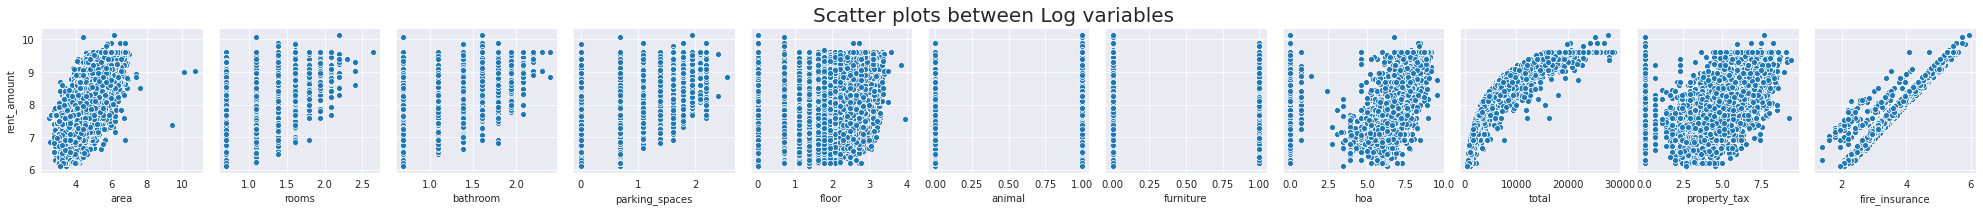

In [ ]:
ax = sns.pairplot(new_houses, y_vars='rent_amount', x_vars = ['area', 'rooms',
                  'bathroom', 'parking_spaces', 'floor', 'animal', 'furniture',
                  'hoa', 'total', 'property_tax', 'fire_insurance'])
ax.fig.suptitle('Scatter plots between Log variables', fontsize=20, y=1.1)
ax

We can see that the some features is more 'linearly related' with the target variable.

### Predict

In [ ]:
y = new_houses['rent_amount'] 
x = new_houses.drop(['rent_amount','animal','rooms','total','area'], axis = 1) 

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                   test_size=0.3,
                                                   random_state = 8)

reg = LinearRegression() 
reg.fit(x_train, y_train) 
predict = reg.predict(x_test)

x_train_constant = sm.add_constant(x_train)
model_sm = sm.OLS(y_train, x_train_constant, hascont = True).fit()
print(model_sm.summary())

print('MAE: ', mean_absolute_error(y_test, predict).round(3))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, predict)).round(3))
print('R2:', r2_score(y_test, predict).round(3))

metrics.append(np.sqrt(mean_squared_error(y_test, predict)))

                            OLS Regression Results                            
Dep. Variable:            rent_amount   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 4.007e+04
Date:                Thu, 13 Aug 2020   Prob (F-statistic):               0.00
Time:                        13:07:37   Log-Likelihood:                 6515.9
No. Observations:                7474   AIC:                        -1.301e+04
Df Residuals:                    7462   BIC:                        -1.292e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.4699    

I got a good RMSE, but Warning tells me that there is multicollinearity in the data, so I have problemns with my features.

# 3° try

### Cleaning

In [ ]:
drop_hoa = new_houses.query('hoa =="0"').index
new_houses.hoa.drop(drop_hoa, inplace = True)

drop_property = new_houses.query('property_tax =="0"').index
new_houses.property_tax.drop(drop_property, inplace = True)

Dropped the values that don't have any information for the model 

### Feature Scaling

If you don't know what is Feature Scaling, you can look at <a href='https://en.wikipedia.org/wiki/Feature_scalingi'>Wikipedia</a> and a good post <a href='https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e'>here</a>, but the principles are simple: <br> Transform the variables into the same magnitude.
Maybe this doesn't change anything because I already changed the real values of columns to your respectives Logs (but I have to try)

In [ ]:
y = new_houses['rent_amount'] 
x = new_houses.drop(['rent_amount','total','rooms','animal','area','city_Campinas'], axis = 1) 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                   random_state = 8)

In [ ]:
#Scaling 
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

### Predict

In [ ]:
reg = LinearRegression() 
reg.fit(x_train, y_train) 
predict = reg.predict(x_test)

x_train_constant = sm.add_constant(x_train)
model_sm = sm.OLS(y_train, x_train_constant, hascont = True).fit()
print(model_sm.summary())
print('MAE: ', mean_absolute_error(y_test, predict).round(3))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, predict)).round(3))
print('R2:', r2_score(y_test, predict).round(3))

metrics.append(np.sqrt(mean_squared_error(y_test, predict)))

                            OLS Regression Results                            
Dep. Variable:            rent_amount   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 4.634e+04
Date:                Thu, 13 Aug 2020   Prob (F-statistic):               0.00
Time:                        13:07:37   Log-Likelihood:                 7440.1
No. Observations:                8542   AIC:                        -1.486e+04
Df Residuals:                    8530   BIC:                        -1.477e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9422      0.001   7243.100      0.0

Now the model don't have problems with  multicollinearity between the features.
I have a RMSE a little worse but not significant.

# The last one

### Grouping

In this last model I'll use everything that worked and try some other analysis.

In [ ]:
group = houses.groupby('city')['rent_amount']

Q1 = group.quantile(.25)
Q3 = group.quantile(.75)
IIQ = Q3 - Q1  
down_limit = Q1 - 1.5* IIQ
up_limit = Q3 + 1.5* IIQ

I grouped the rent_amount by city to create a boxplot with Outliers excluded.

In [ ]:
new_df = pd.DataFrame() #Creating a empty df

for city in group.groups.keys():
        cities = houses['city'] == city #selecting boolean values of cities
        limits = (houses['rent_amount'] >= down_limit[city]) & (houses['rent_amount'] <= up_limit[city]) #put the boxplot limit
        queries = cities & limits #query cities and limits
        selected = houses[queries] #put the query above in houses
        new_df = pd.concat([new_df, selected]) #concatenating the empty df in the df who I processed
new_df.head() #viewing

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
21,Belo Horizonte,42,1,1,1,17,0,1,470,2690,172,36,3368
27,Belo Horizonte,64,2,2,1,11,1,0,352,1500,80,20,1952
42,Belo Horizonte,200,4,2,1,7,0,0,850,2550,9,34,3443
43,Belo Horizonte,45,1,1,1,5,1,0,500,1631,192,12,2335
46,Belo Horizonte,100,3,1,0,13,0,0,700,1220,10,17,1947


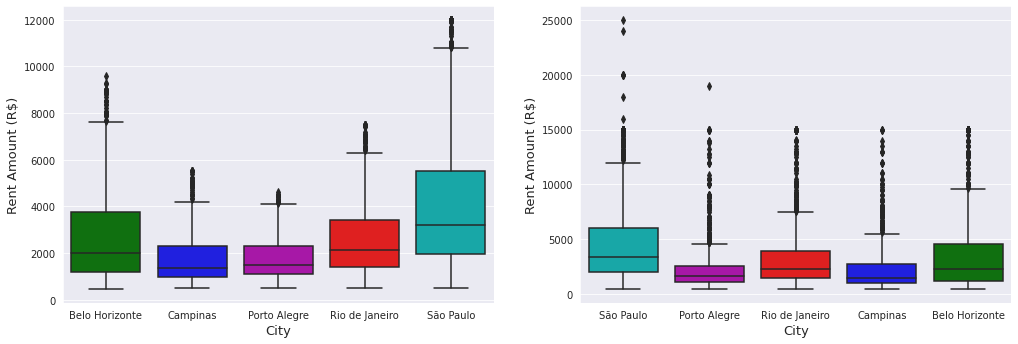

In [ ]:
plt.figure(figsize=(17,12))
color = {'Belo Horizonte':'g', 'Campinas':'b', 'Porto Alegre':'m',
         'Rio de Janeiro':'r', 'São Paulo':'c'}

plt.subplot(2, 2, 1)
ax = sns.boxplot(x = 'city', y = 'rent_amount', data = new_df, palette = color)
ax.set_xlabel('City', fontsize=13)
ax.set_ylabel('Rent Amount (R$)', fontsize=13)

plt.subplot(2, 2, 2)
ax = sns.boxplot(x = 'city', y = 'rent_amount', data = houses, palette = color)
ax.set_xlabel('City', fontsize=13)
ax.set_ylabel('Rent Amount (R$)', fontsize=13)
ax

Great visualization difference. Now I can conclude with more precision:

1. The cities with the most dispersed rent amount are São Paulo and Belo Horizonte <br>
2. The scale is different because I used Standard Scaler but I can conclude that 75% of the rent amount values in Porto Alegre and Campinas are below 50% of the data in Rio de Janeiro. Which indicates a higher rent amount in houses in Rio de Janeiro.

In [ ]:
features = ['floor','bathroom','rooms','parking_spaces',
            'hoa', 'rent_amount', 'property_tax', 'fire_insurance']

for item in features:
    new_df[item] = np.log1p(new_df[item])

In [ ]:
y = new_df['rent_amount'] 
x = new_df.drop(['rent_amount','city','rooms','area','total'], axis = 1) 

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                   test_size=0.2,
                                                   random_state = 8) 

### Predict

In [ ]:
reg = LinearRegression() 
reg.fit(x_train, y_train) 
predict = reg.predict(x_test)

x_train_constant = sm.add_constant(x_train)
model_sm = sm.OLS(y_train, x_train_constant, hascont = True).fit()
print(model_sm.summary())

print('MAE: ', mean_absolute_error(y_test, predict).round(3))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, predict)).round(3))
print('R2:', r2_score(y_test, predict).round(3))

metrics.append(np.sqrt(mean_squared_error(y_test, predict)))

                            OLS Regression Results                            
Dep. Variable:            rent_amount   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 3.558e+04
Date:                Thu, 13 Aug 2020   Prob (F-statistic):               0.00
Time:                        13:07:38   Log-Likelihood:                 5782.1
No. Observations:                7972   AIC:                        -1.155e+04
Df Residuals:                    7963   BIC:                        -1.148e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.1404      0.008    499.

Analyzing residuals

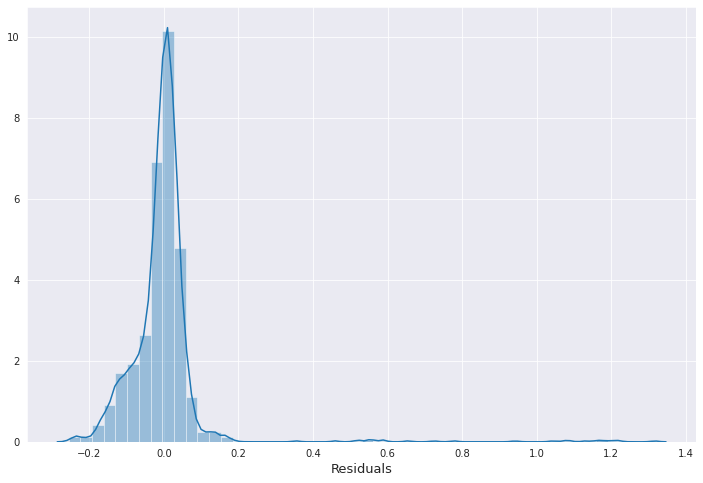

In [ ]:
resid = y_test - predict
ax = sns.distplot(resid)
ax.figure.set_size_inches(12,8)
ax.set_xlabel('Residuals', fontsize=13)
ax

Considering the Central Limit Theorem and the sample size of this study, it will be considered asymptotic normality in the distribution of errors.

---



### Coefficients of regression

In [ ]:
#confirming the order of columns
x.columns

Index(['bathroom', 'parking_spaces', 'floor', 'animal', 'furniture', 'hoa',
       'property_tax', 'fire_insurance'],
      dtype='object')

In [ ]:
index = ['Intercept','Log bathroom', 'Log parking_spaces','Log floor','Log Animal','Log furniture',
         'Log hoa', 'Log property_tax','Log fire_insurance']

pd.DataFrame(data=np.append(reg.intercept_, reg.coef_), index=index, columns=['Parâmetros'])

,Parâmetros
Intercept,4.140388
Log bathroom,0.028806
Log parking_spaces,0.010209
Log floor,0.028915
Log Animal,-0.011758
Log furniture,0.022565
Log hoa,0.014715
Log property_tax,-0.003955
Log fire_insurance,0.998273


### Interpretation of coefficients

In [ ]:
np.exp(reg.intercept_).round(2)

62.83

Intercept => Excluding the effect of explain variables ($X_2=X_3= ...X_n=0$), the medium effect in rent amount will be R$ 61,83 (exp(4.124213)).

Bathroons => Keeping the other features constant, an increase of 1% in the number of bathrooms generates an increase of 0.03% on average in the rent amount of the property.

Fire Insurance => Keeping the other features constant, an increase of 1% in price of fire insurance generates an increase of almost one percent on average in the rent amount of the property.

And we can do this for all features.

### Value predict and real value

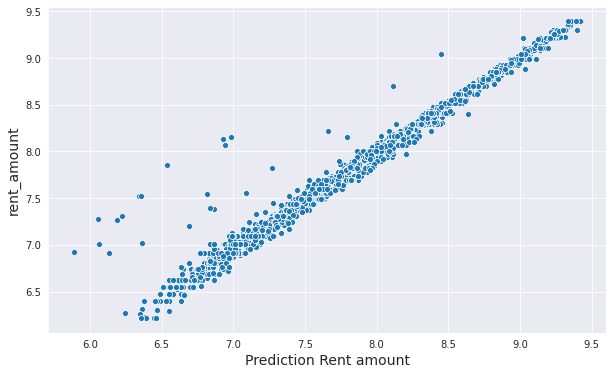

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('Prediction Rent amount', fontsize = 14)
plt.ylabel('rent_amount', fontsize = 14)

sns.scatterplot(predict, y_test)

This graph shows a fictitious line between the data actually observed and what the model predicted. It is possible to observe several points outside the line, but it was the best predict I got without multicollinearity.


# Comparing the results

Showing RMSE from each attempt

In [ ]:
attempts = ['first','second','third','fourth']

for attempt, metric in zip(attempts, metrics):
  print(attempt, ':', metric)

first : 462.258908052961
second : 0.11002111438294104
third : 0.11389962202040202
fourth : 0.11353201317501205


# Conclusion

In this Data Science Project I used Data Viz with seaborn and matplotlib to improve the understanding of some variables from the data, pandas and numpy to handle and analyzing some columns, and using statsmodels to have a statistical comprehesion of the dataset and verifying if i was can use the Linear Regression model. 

In addition, I put the data on a logarithmic scale, use the StandardScaler and I tried to group some data to reduce the multicollinearity and clear the data. Of course, I apply some sklearn modules to splitting the dataset, do prediction and know how efficient my model is.

We were able to observe in the comparison of the results that the second attempt was the one with the best RMSE, but there was multicollinearity in the data and linear regression assumes no multicollinearity, so I had to change something in the model.

After trying to adjust the model, as previously spoken, I got the fourth attempt as the best RMSE (in this Post I showed only the first, second and fourth attempts, to see the third one just access my Github). I hope you enjoyed this study.

If you wanna to talk with me, this is my <a href='https://www.linkedin.com/in/juliohenri/'>LinkedIn</a> and you can see others projects in my <a href='https://github.com/JulioHenri'>GitHub</a>. Thank you! (: